# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [49]:
# Import numpy and pandas
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# Your code here:
sensor.info()
#There is no missing data
sensor.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attitude.roll       1751 non-null   float64
 1   attitude.pitch      1751 non-null   float64
 2   attitude.yaw        1751 non-null   float64
 3   gravity.x           1751 non-null   float64
 4   gravity.y           1751 non-null   float64
 5   gravity.z           1751 non-null   float64
 6   rotationRate.x      1751 non-null   float64
 7   rotationRate.y      1751 non-null   float64
 8   rotationRate.z      1751 non-null   float64
 9   userAcceleration.x  1751 non-null   float64
 10  userAcceleration.y  1751 non-null   float64
 11  userAcceleration.z  1751 non-null   float64
dtypes: float64(12)
memory usage: 164.3 KB


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [7]:
# Your code here:
sensor.shape
#1751 rows and 12 columns

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [12]:
# Your code here:
per1 = pd.date_range(start ='1-1-2018 00:00:00',  
         end ='1-05-2018 00:29:10',periods=len(sensor))
per1

DatetimeIndex([          '2018-01-01 00:00:00',
               '2018-01-01 00:03:18.485714285',
               '2018-01-01 00:06:36.971428571',
               '2018-01-01 00:09:55.457142857',
               '2018-01-01 00:13:13.942857142',
               '2018-01-01 00:16:32.428571428',
               '2018-01-01 00:19:50.914285714',
                  '2018-01-01 00:23:09.400000',
               '2018-01-01 00:26:27.885714285',
               '2018-01-01 00:29:46.371428571',
               ...
               '2018-01-04 23:59:23.628571428',
               '2018-01-05 00:02:42.114285714',
                  '2018-01-05 00:06:00.600000',
               '2018-01-05 00:09:19.085714285',
               '2018-01-05 00:12:37.571428571',
               '2018-01-05 00:15:56.057142857',
               '2018-01-05 00:19:14.542857142',
               '2018-01-05 00:22:33.028571428',
               '2018-01-05 00:25:51.514285714',
                         '2018-01-05 00:29:10'],
              dtype=

Assign the time series index to the dataframe's index.

In [15]:
# Your code here:
sensor.index = pd.DatetimeIndex(per1)
sensor.index
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00.000000000,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:03:18.485714285,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:06:36.971428571,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:09:55.457142857,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:13:13.942857142,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

<ipython-input-23-fa50de33bf1a>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'],freq=60)


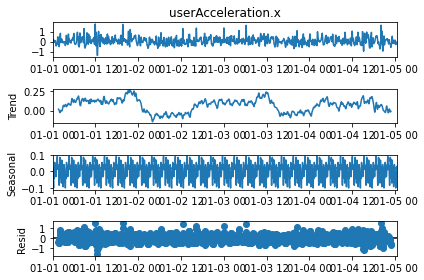

In [23]:
# Your code here:
 
res = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'],freq=60)
resplot = res.plot()
plt.show()

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

<ipython-input-24-558ec6ba69d4>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(sensor['rotationRate.x'],freq=60)


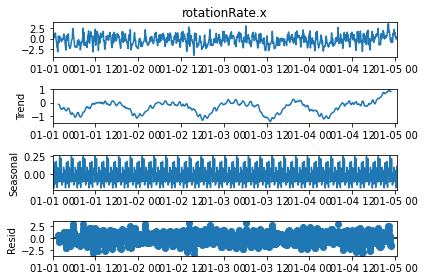

In [24]:
res = sm.tsa.seasonal_decompose(sensor['rotationRate.x'],freq=60)
resplot = res.plot()
plt.show()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

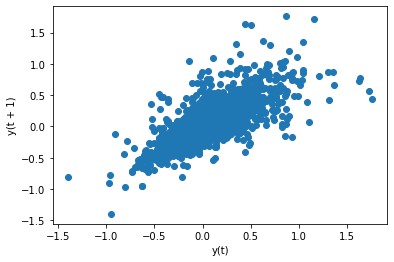

In [28]:
# Your code here:
 
lag_plot(sensor['userAcceleration.x'])


Create a lag plot for `rotationRate.x`

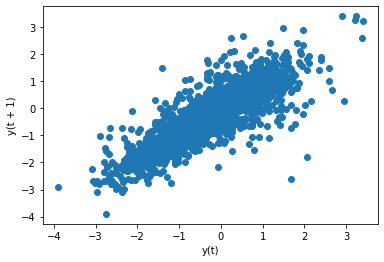

In [29]:
# Your code here:
lag_plot(sensor['rotationRate.x'])


What are your conclusions from both visualizations?

In [11]:
# Your conclusions here:
#both plots shows a positive linear correlation.


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [33]:
# Your code here:
print(adfuller(sensor['userAcceleration.x'])[1])
print(adfuller(sensor['rotationRate.x'])[1])


2.823439483037483e-30
6.320230335912605e-06


What are your conclusions from this test?

In [13]:
# Your conclusions here:
#The p-value is less than 0.05. Therefore, with a 95% confidence interval, we reject the null hypothesis 
#and conclude that the data is stationary.


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [63]:
# Your code here:
Train_data=sensor['userAcceleration.x'][0:-10]
Test_data=sensor['userAcceleration.x'][-10:]

model = ARMA(Train_data, order=(2, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(0, 9)

print(predictions)
print(Test_data)
print(predictions.values)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


2018-01-01 00:00:00.000000000    0.063742
2018-01-01 00:03:18.485714285    0.239253
2018-01-01 00:06:36.971428571    0.127265
2018-01-01 00:09:55.457142857   -0.068711
2018-01-01 00:13:13.942857142    0.023542
2018-01-01 00:16:32.428571428    0.257242
2018-01-01 00:19:50.914285714    0.099381
2018-01-01 00:23:09.400000000    0.035967
2018-01-01 00:26:27.885714285    0.069458
2018-01-01 00:29:46.371428571    0.071279
dtype: float64
2018-01-04 23:59:23.628571428    0.149749
2018-01-05 00:02:42.114285714    0.038461
2018-01-05 00:06:00.600000000   -0.169175
2018-01-05 00:09:19.085714285   -0.300361
2018-01-05 00:12:37.571428571   -0.270174
2018-01-05 00:15:56.057142857   -0.268367
2018-01-05 00:19:14.542857142   -0.102444
2018-01-05 00:22:33.028571428   -0.085590
2018-01-05 00:25:51.514285714   -0.048105
2018-01-05 00:29:10.000000000   -0.065011
Name: userAcceleration.x, dtype: float64
[ 0.06374177  0.23925278  0.12726536 -0.06871089  0.02354221  0.25724154
  0.09938127  0.03596739  0.069

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

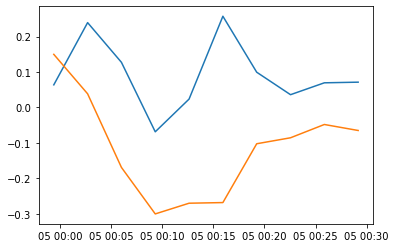

In [64]:
# Your code here:
#print(predictions)
rmse(predictions,Test_data)
plt.plot(Test_data.index,predictions.values)
plt.plot(Test_data)

In [ ]:
#We can saw a bad prediction.